# Leave-one-out cross-validation

General steps for LOO cross-validation:
- Remove i-th datum from input data set
- Fit model to remaining data set
- Use fitted model to predict the i-th datum and store difference to original i-th datum
- Do this for all i and compute variance of the differences
- Select model with smallest variance

I demonstrate below how to select the optimal order for a polynomial model with leave-one-out (LOO) cross validation.

In [1]:
#!pip install numpy matplotlib iminuit tabulate
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit 
from tabulate import tabulate

In [2]:
rng = np.random.default_rng(seed=1)

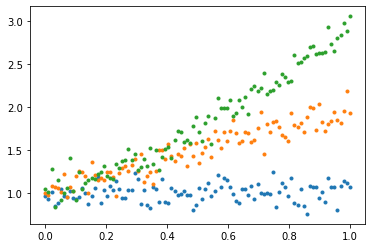

In [15]:
# create some toy data that follows polynomials of increasing degree
x = np.linspace(0, 1, 100)
y_set = np.empty((3, len(x)))
for poly_degree in (0, 1, 2):
    y_set[poly_degree] = np.polyval(np.ones(poly_degree + 1), x) + rng.normal(0, 0.1, len(x))
    
for y in y_set:
    plt.plot(x, y, ".")

In [16]:
# apply leave-one-out cross-validation
for true_poly_order, y in enumerate(y_set):

    variances = []
    tested_poly_orders = np.arange(5)
    for tested_poly_order in tested_poly_orders:
        deltas = []

        # leave out the i-th (x, y) pair in the fit
        for i in range(len(y)):
            mask = np.ones(len(y), dtype=bool)
            mask[i] = 0
            x_without_i = x[mask]
            y_without_i = y[mask]

            # least-squares cost function to fit a polynomial to the toy data
            def lsq(par):
                ym = np.polyval(par, x_without_i)
                return np.sum((y_without_i - ym) ** 2 / 0.1 ** 2)
            
            m = Minuit.from_array_func(lsq, np.zeros(tested_poly_order+1), pedantic=False)
            m.strategy = 0 # faster and does not compute errors automatically
            m.migrad()

            # predict the i-th y value with the fitted model and 
            # store the delta to the real value
            assert m.migrad_ok()
            
            yi_predicted = np.polyval(m.np_values(), x[i])
            deltas.append(y[i] - yi_predicted)

        variances.append(np.var(deltas))

    print(f"true polynomial order {true_poly_order}; selected order {np.argmin(variances)}")
    print(tabulate(np.transpose((tested_poly_orders, variances)),
                   headers=("model order", "LOO variance")) + "\n")

true polynomial order 0; selected order 0
  model order    LOO variance
-------------  --------------
            0       0.0105525
            1       0.0105614
            2       0.0107262
            3       0.0107479
            4       0.0107608

true polynomial order 1; selected order 1
  model order    LOO variance
-------------  --------------
            0       0.0903401
            1       0.0121111
            2       0.0122902
            3       0.0124952
            4       0.0124547

true polynomial order 2; selected order 2
  model order    LOO variance
-------------  --------------
            0       0.347969
            1       0.017877
            2       0.0117249
            3       0.0118761
            4       0.011895

